# Linear Regression Model Training
### Read in features and labels
### Do some multivariate linear regression
### See how good the fits are

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr

%matplotlib inline

In [2]:
# read in features and labels/examples (see build_features_labels2.ipynb for more info)
features = pd.read_csv('data_final/features.csv')
print features.shape
print features.columns
features[:10]

(314, 50)
Index([u'census_tract', u'bus_age', u'n_business', u'n_businesses_11',
       u'n_businesses_21', u'n_businesses_22', u'n_businesses_23',
       u'n_businesses_31', u'n_businesses_32', u'n_businesses_33',
       u'n_businesses_42', u'n_businesses_44', u'n_businesses_45',
       u'n_businesses_48', u'n_businesses_49', u'n_businesses_51',
       u'n_businesses_52', u'n_businesses_53', u'n_businesses_54',
       u'n_businesses_55', u'n_businesses_56', u'n_businesses_61',
       u'n_businesses_62', u'n_businesses_71', u'n_businesses_72',
       u'n_businesses_81', u'n_businesses_92', u'population',
       u'population_percent_male', u'population_percent_female', u'age_med',
       u'age_med_male', u'age_med_female', u'minor_percent', u'adult_percent',
       u'homes', u'homes_percent_mortgage', u'homes_percent_clear',
       u'homes_percent_rent', u'employment_percent', u'income_med',
       u'income_med_owner', u'income_med_renter', u'cost_med',
       u'cost_med_owner', u'cost_

,census_tract,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,...,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,walk_score,transit_score,bike_score,total_amount
0,100,0.541876,0.040244,0.25,0.0,0.0,0.027027,0.000000,0.000,0.006757,...,0.615612,0.499898,0.147354,0.513829,0.48075,0.9195,0.701031,0.592593,0.583333,0.000000
1,201,0.538251,0.055183,0.00,0.0,0.0,0.032432,0.000000,0.000,0.006757,...,0.566840,0.684250,0.227237,0.362798,0.56075,0.4870,0.701031,0.592593,0.583333,0.021766
2,202,0.541876,0.055793,0.25,0.0,0.0,0.054054,0.000000,0.000,0.000000,...,0.434022,0.417067,0.318495,0.422722,0.50650,0.7225,0.618557,0.617284,0.500000,0.059047
3,300,0.486091,0.150000,0.25,0.0,0.0,0.037838,0.058824,0.025,0.027027,...,0.356844,0.491126,0.270861,0.377983,0.57750,0.6410,0.835052,0.666667,0.690476,0.357875
4,400,0.516499,0.146037,0.00,0.0,0.0,0.021622,0.029412,0.000,0.006757,...,0.396237,0.347169,0.358638,0.352223,0.46750,0.6275,0.835052,0.666667,0.690476,0.234442
5,500,0.449023,0.061280,0.00,0.0,0.0,0.027027,0.058824,0.000,0.000000,...,0.317670,0.366111,0.265293,0.331887,0.45475,0.5725,0.814433,0.666667,0.797619,0.011336
6,600,0.387541,0.076220,0.00,0.0,0.0,0.027027,0.029412,0.000,0.000000,...,0.323496,0.349367,0.281653,0.329718,0.39675,0.5905,0.814433,0.666667,0.797619,0.006188
7,700,0.446434,0.064939,0.25,0.0,0.0,0.032432,0.058824,0.025,0.006757,...,0.399066,0.505572,0.327974,0.365239,0.60425,0.6205,0.835052,0.666667,0.690476,0.062528
8,800,0.360758,0.040549,0.00,0.0,0.0,0.016216,0.000000,0.000,0.006757,...,0.261325,0.401084,0.215931,0.296367,0.45200,0.5055,0.000000,0.000000,0.000000,0.007590
9,900,0.264131,0.071341,0.00,0.0,0.0,0.016216,0.088235,0.050,0.006757,...,0.266590,0.271528,0.229727,0.286334,0.45100,0.4975,0.814433,0.666667,0.797619,0.016920


## Look for correlated features

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


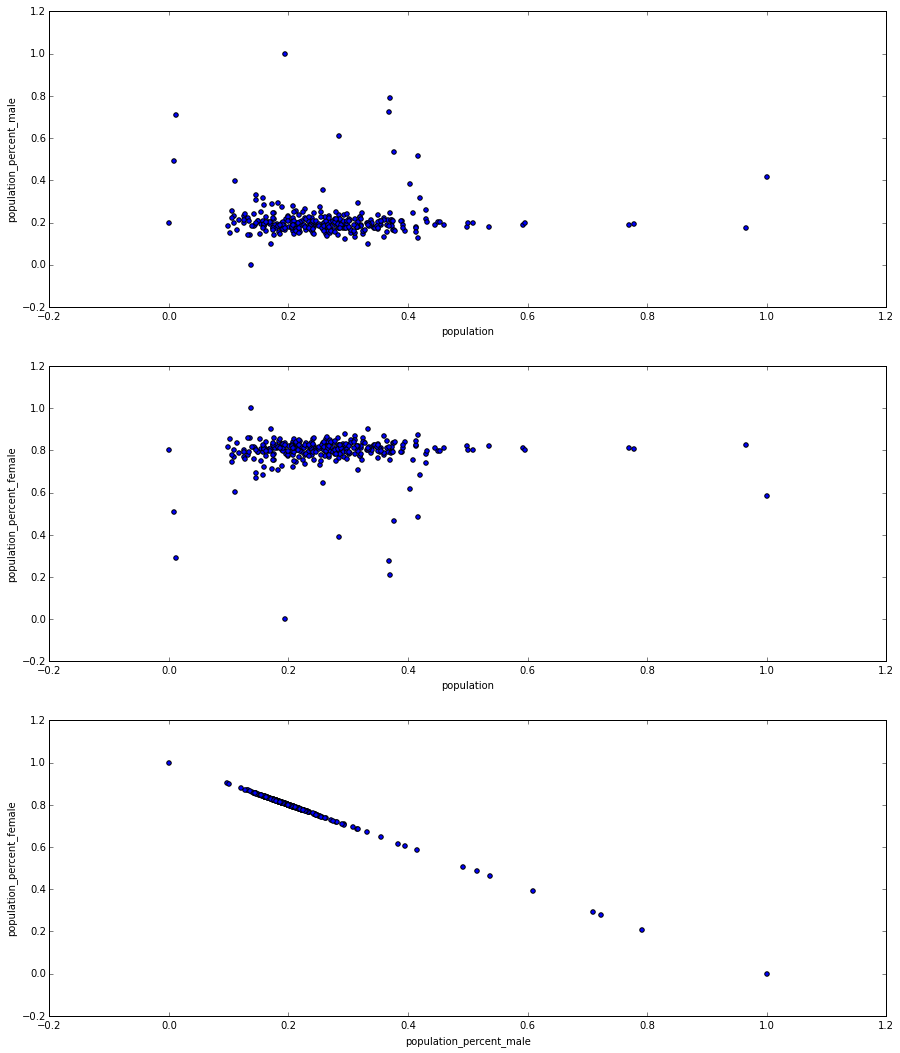

In [3]:
# plot features vs. each other
fig, axs = plt.subplots(3,1, sharey=True)
features.plot(kind='scatter', x='population', y='population_percent_male', ax=axs[0], figsize=(15, 18))
features.plot(kind='scatter', x='population', y='population_percent_female', ax=axs[1])
features.plot(kind='scatter', x='population_percent_male', y='population_percent_female', ax=axs[2])

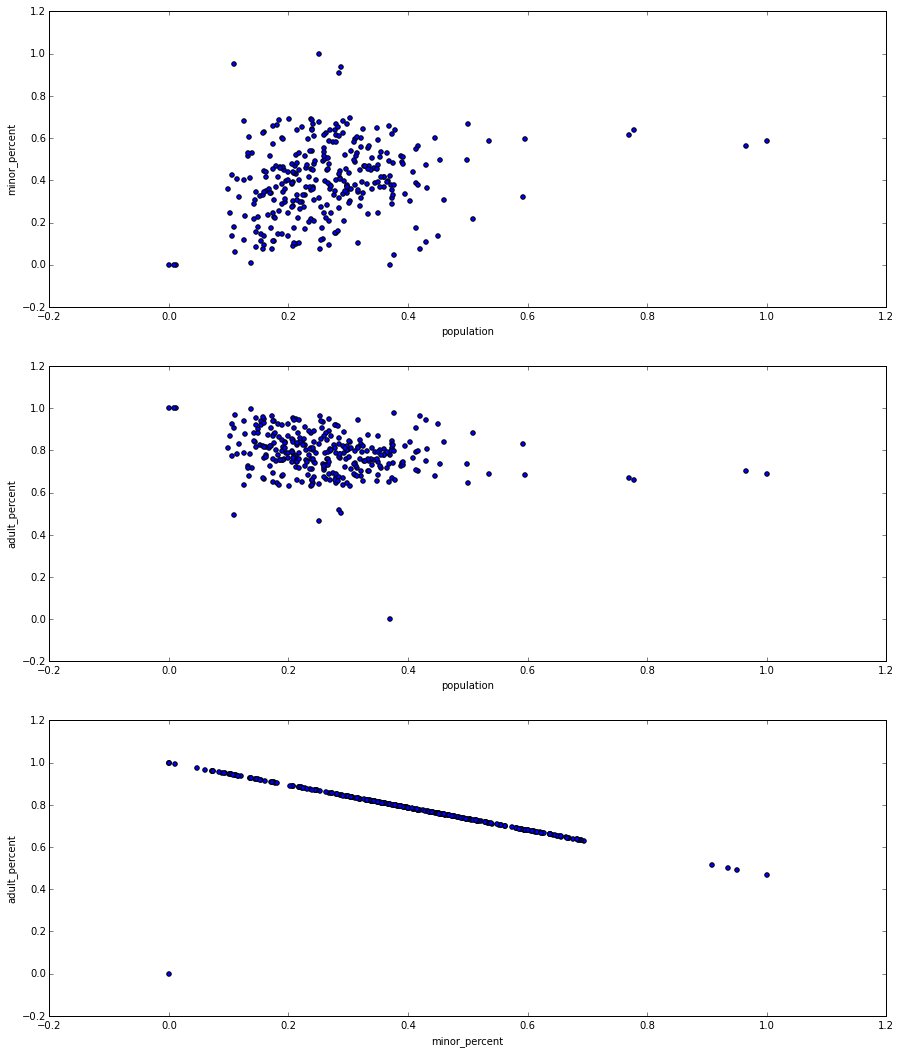

In [4]:
# plot features vs. each other
fig, axs = plt.subplots(3,1, sharey=True)
features.plot(kind='scatter', x='population', y='minor_percent', ax=axs[0], figsize=(15, 18))
features.plot(kind='scatter', x='population', y='adult_percent', ax=axs[1])
features.plot(kind='scatter', x='minor_percent', y='adult_percent', ax=axs[2])

(0.98740634343047118, 6.5522747087192956e-252)
(0.98616964813675545, 1.3214691619984144e-245)
(0.94910183855863772, 1.3701352243360731e-158)


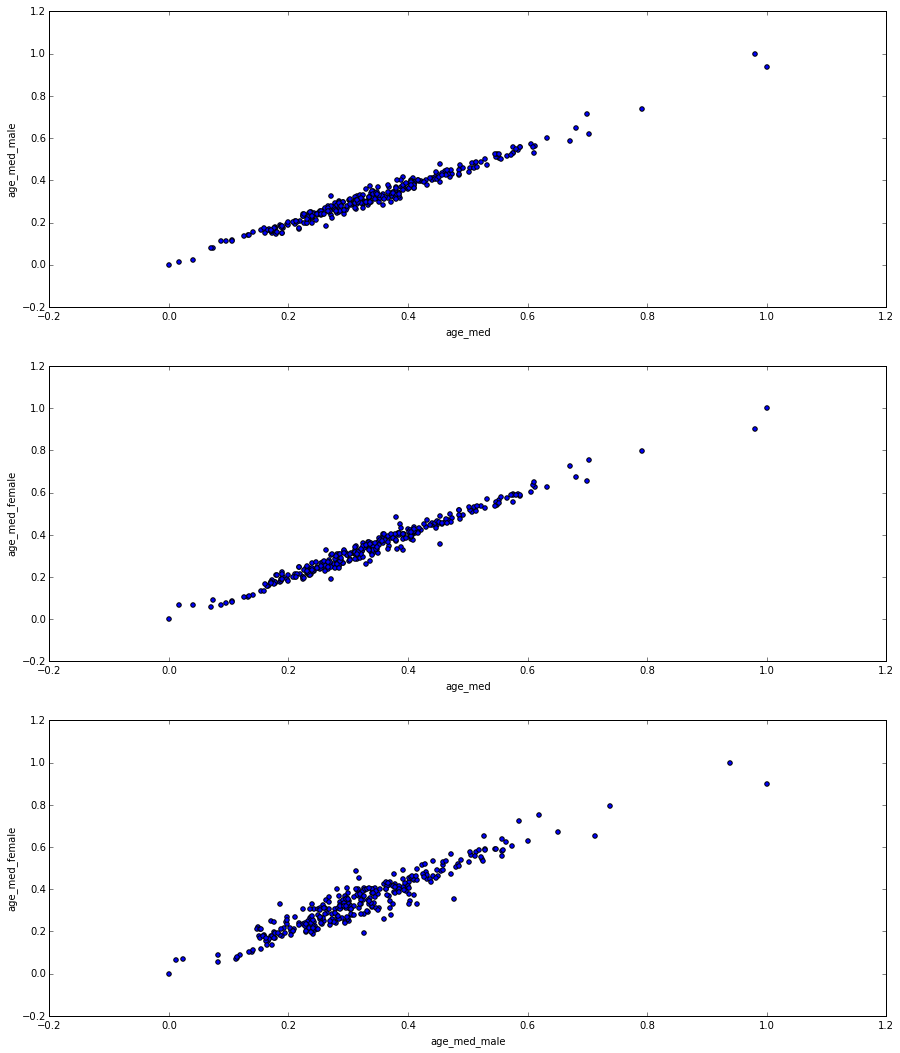

In [5]:
# plot features vs. each other
fig, axs = plt.subplots(3,1, sharey=True)
features.plot(kind='scatter', x='age_med', y='age_med_male', ax=axs[0], figsize=(15, 18))
# first value is the r-value, second is the p-value
print pearsonr(features.age_med,features.age_med_male)
features.plot(kind='scatter', x='age_med', y='age_med_female', ax=axs[1])
print pearsonr(features.age_med,features.age_med_female)
features.plot(kind='scatter', x='age_med_male', y='age_med_female', ax=axs[2])
print pearsonr(features.age_med_female,features.age_med_male)

(0.30601361801052224, 3.1251712186450032e-08)
(-0.90996791259916032, 2.6378546907706509e-121)
(-0.61178165589999245, 1.2626081680277716e-33)


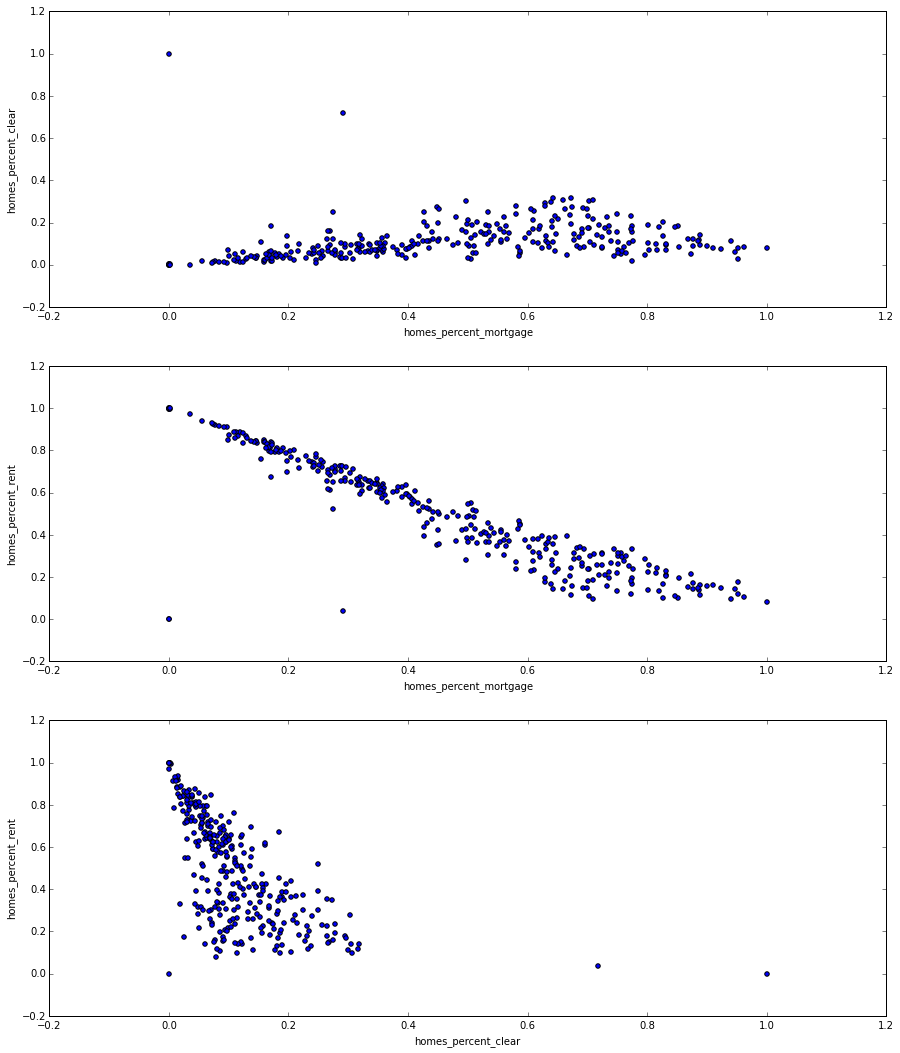

In [6]:
# plot features vs. each other
fig, axs = plt.subplots(3,1, sharey=True)
features.plot(kind='scatter', x='homes_percent_mortgage', y='homes_percent_clear', ax=axs[0], figsize=(15, 18))
print pearsonr(features.homes_percent_mortgage,features.homes_percent_clear)
features.plot(kind='scatter', x='homes_percent_mortgage', y='homes_percent_rent', ax=axs[1])
print pearsonr(features.homes_percent_mortgage,features.homes_percent_rent)
features.plot(kind='scatter', x='homes_percent_clear', y='homes_percent_rent', ax=axs[2])
print pearsonr(features.homes_percent_clear,features.homes_percent_rent)

(0.78328491781081733, 2.2328952171697822e-66)
(0.81895417385667846, 3.0745497331727006e-77)
(0.58995537201954507, 7.9222329379736642e-31)


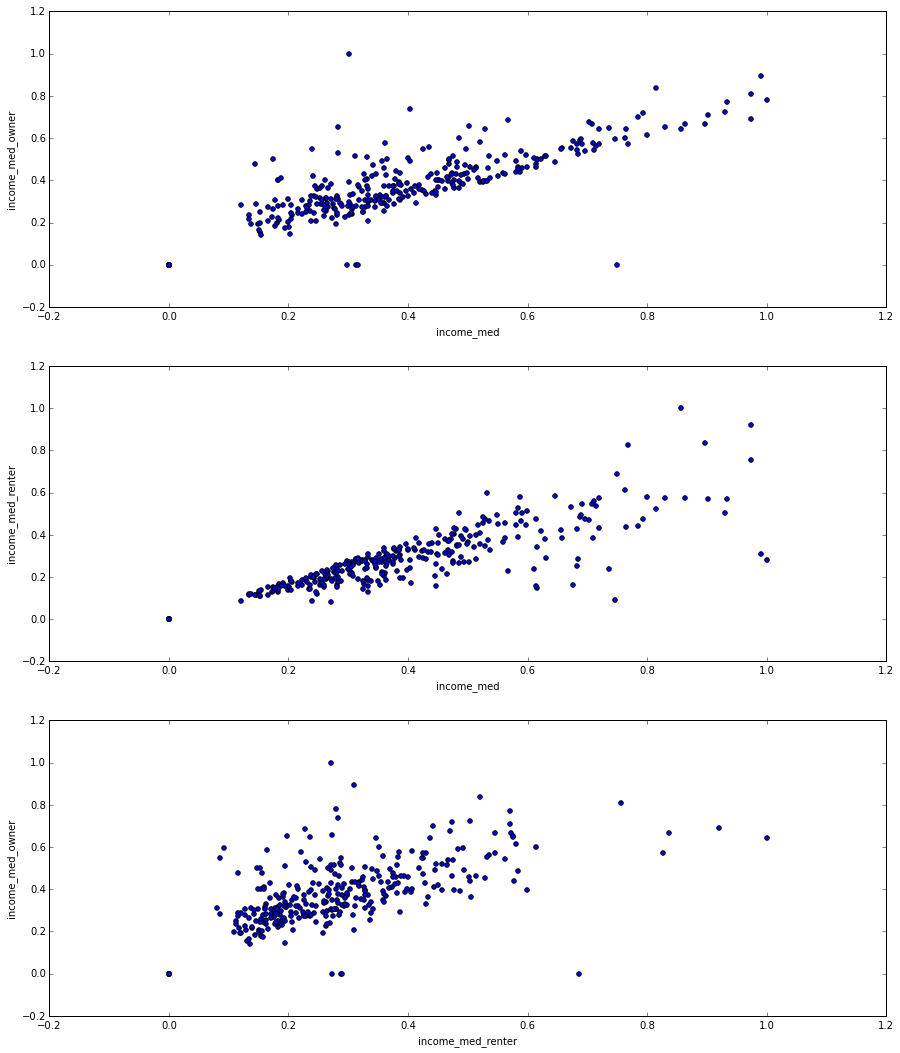

In [7]:
# plot features vs. each other
fig, axs = plt.subplots(3,1, sharey=True)
features.plot(kind='scatter', x='income_med', y='income_med_owner', ax=axs[0], figsize=(15, 18))
print pearsonr(features.income_med,features.income_med_owner)
features.plot(kind='scatter', x='income_med', y='income_med_renter', ax=axs[1])
print pearsonr(features.income_med,features.income_med_renter)
features.plot(kind='scatter', x='income_med_renter', y='income_med_owner', ax=axs[2])
print pearsonr(features.income_med_renter,features.income_med_owner)

(0.7276895135429986, 5.0820414069040754e-53)
(0.84659325766533022, 1.8704371662674589e-87)
(0.52984003196353002, 3.9994084262206345e-24)


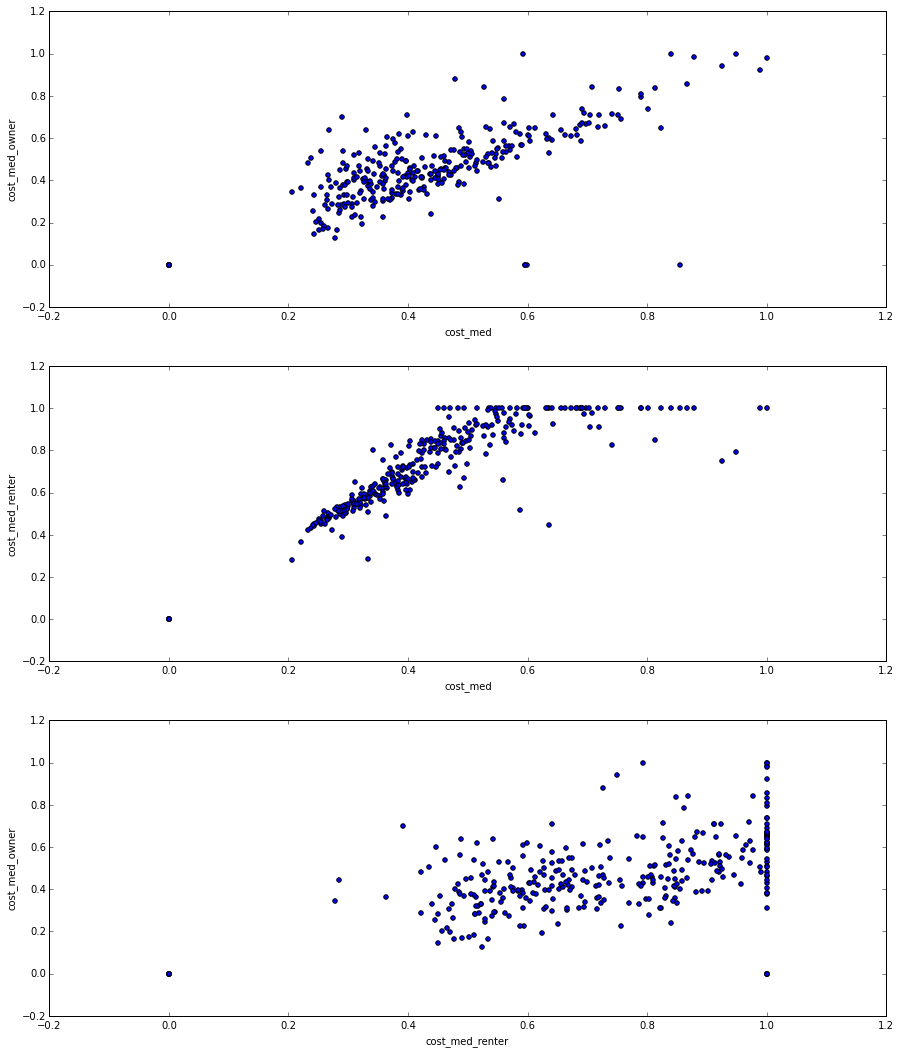

In [8]:
# plot features vs. each other
fig, axs = plt.subplots(3,1, sharey=True)
features.plot(kind='scatter', x='cost_med', y='cost_med_owner', ax=axs[0], figsize=(15, 18))
print pearsonr(features.cost_med,features.cost_med_owner)
features.plot(kind='scatter', x='cost_med', y='cost_med_renter', ax=axs[1])
print pearsonr(features.cost_med,features.cost_med_renter)
features.plot(kind='scatter', x='cost_med_renter', y='cost_med_owner', ax=axs[2])
print pearsonr(features.cost_med_renter,features.cost_med_owner)

(0.92813082732761121, 6.1465269190687674e-136)
(0.90912084295172546, 1.0618078425355541e-120)
(0.8336103168586404, 2.0163362563301657e-82)


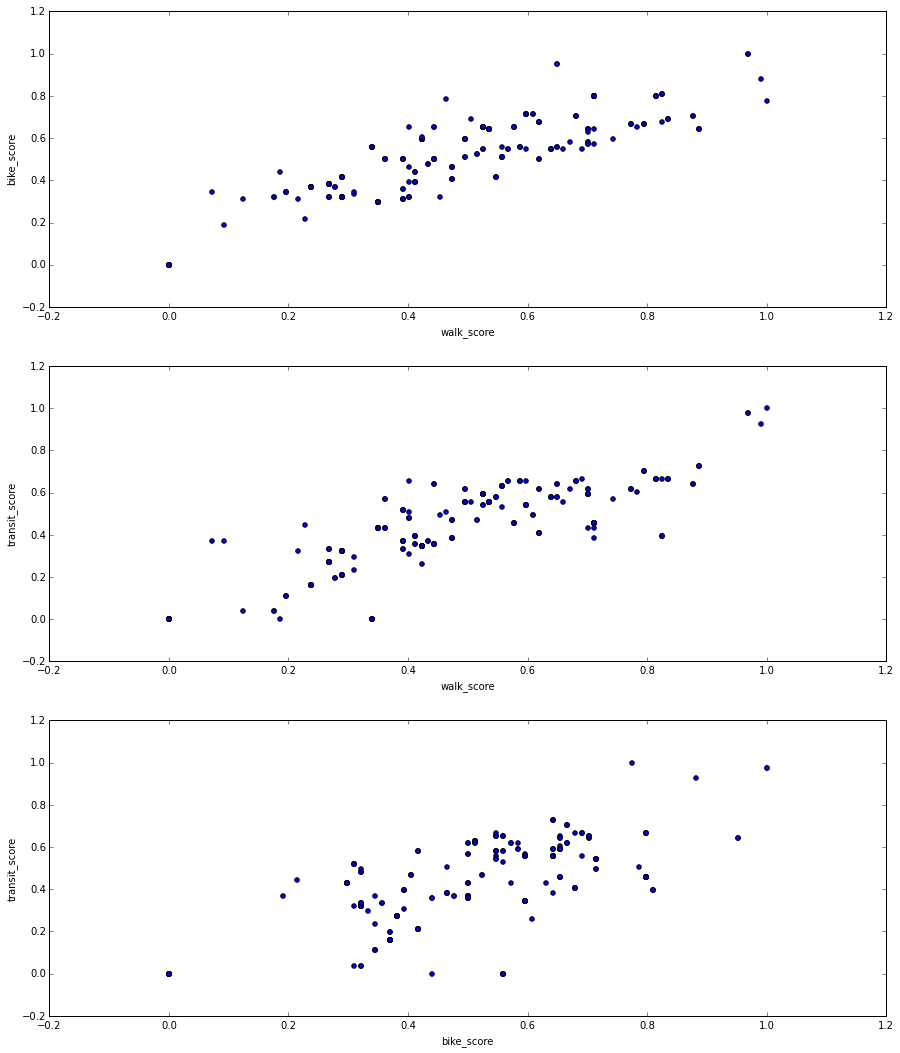

In [9]:
# plot features vs. each other
fig, axs = plt.subplots(3,1, sharey=True)
features.plot(kind='scatter', x='walk_score', y='bike_score', ax=axs[0], figsize=(15, 18))
print pearsonr(features.walk_score,features.bike_score)
features.plot(kind='scatter', x='walk_score', y='transit_score', ax=axs[1])
print pearsonr(features.walk_score,features.transit_score)
features.plot(kind='scatter', x='bike_score', y='transit_score', ax=axs[2])
print pearsonr(features.bike_score,features.transit_score)

## See if individual features are correlated w/ labels

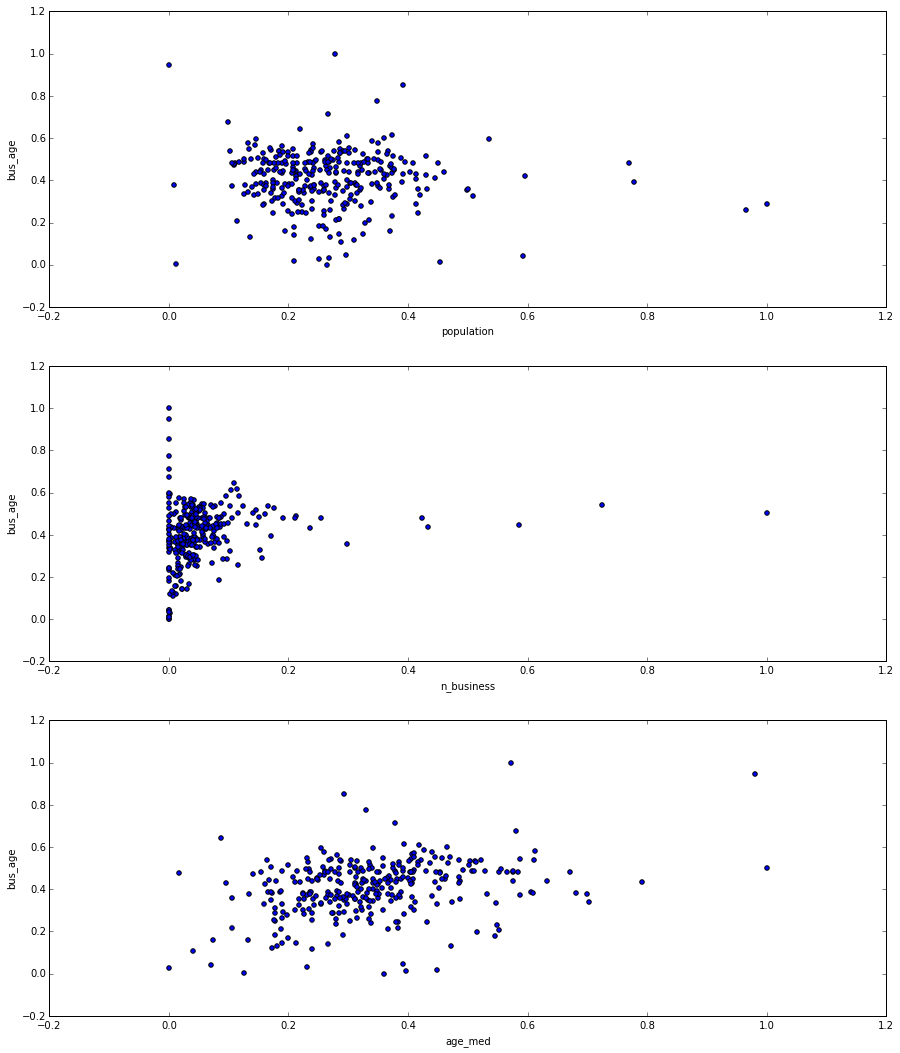

In [10]:
# plot features vs. score
fig, axs = plt.subplots(3,1, sharey=True)
features.plot(kind='scatter', x='population', y='bus_age', ax=axs[0], figsize=(15, 18))
features.plot(kind='scatter', x='n_business', y='bus_age', ax=axs[1])
features.plot(kind='scatter', x='age_med', y='bus_age', ax=axs[2])

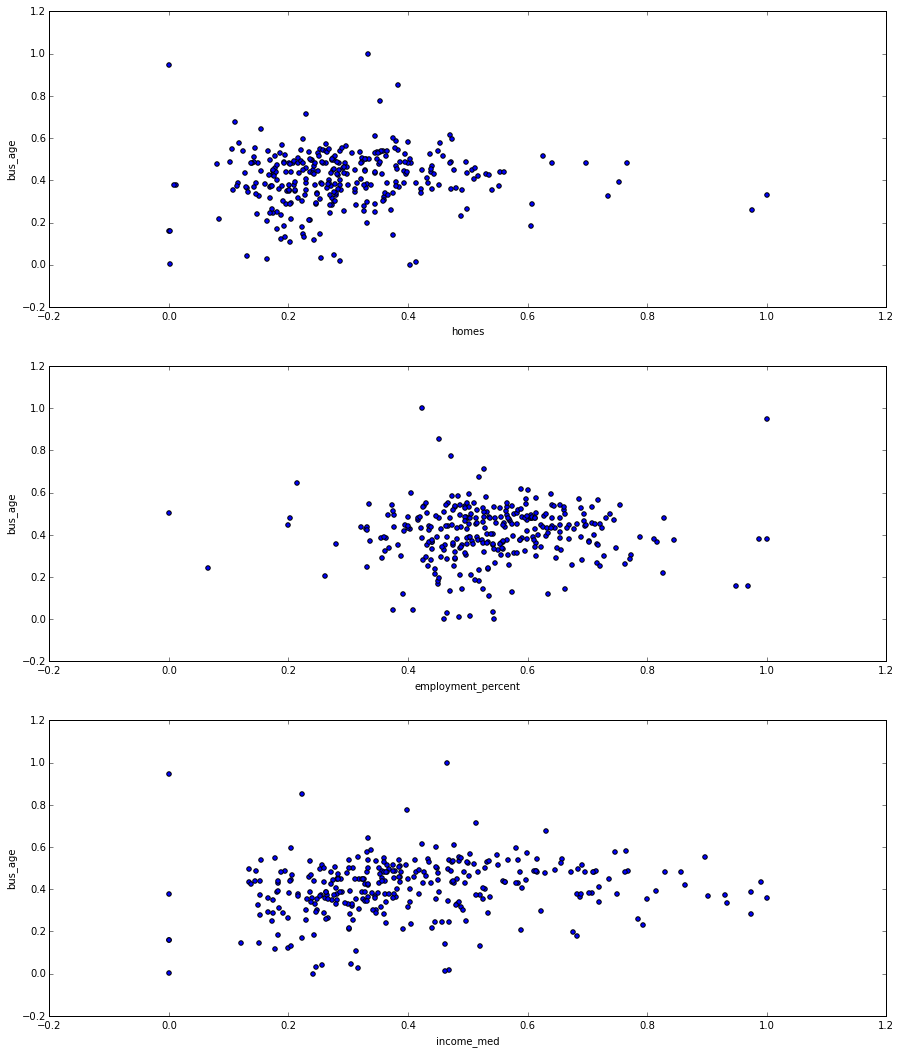

In [11]:
# plot features vs. score
fig, axs = plt.subplots(3,1, sharey=True)
features.plot(kind='scatter', x='homes', y='bus_age', ax=axs[0], figsize=(15, 18))
features.plot(kind='scatter', x='employment_percent', y='bus_age', ax=axs[1])
features.plot(kind='scatter', x='income_med', y='bus_age', ax=axs[2])

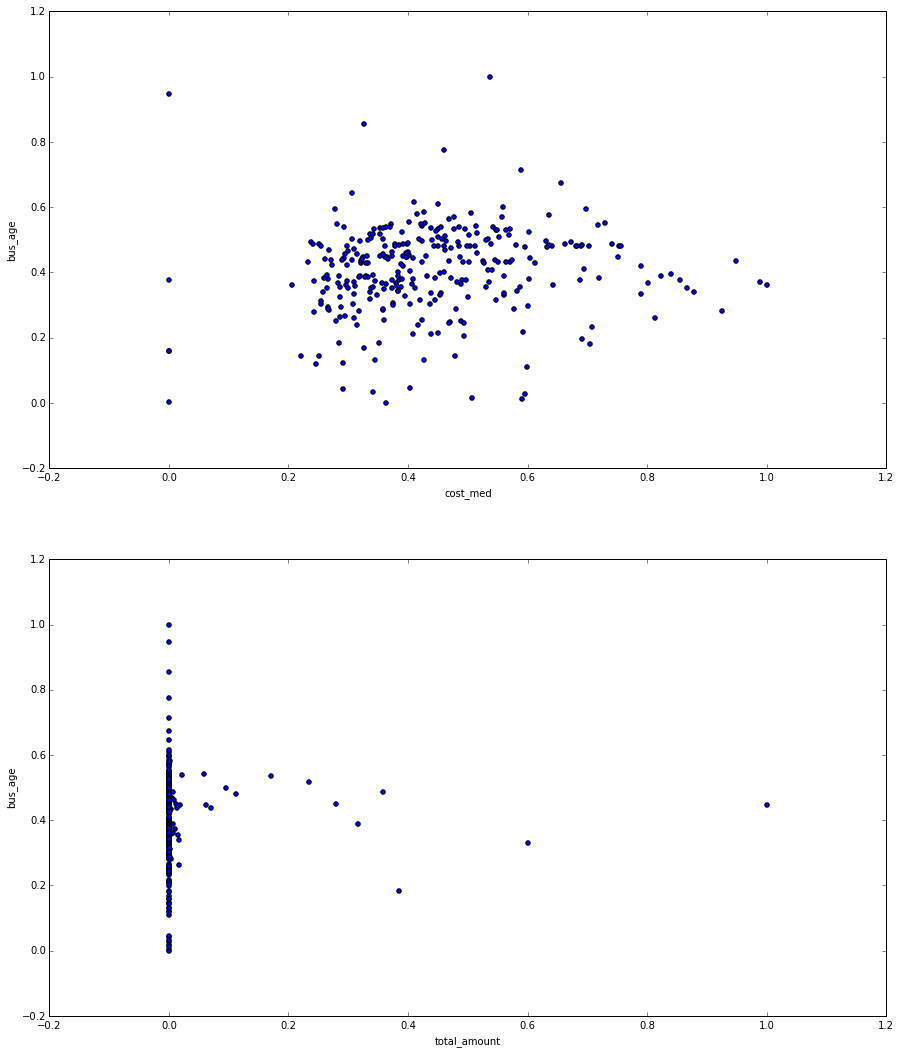

In [12]:
# plot features vs. score
fig, axs = plt.subplots(2,1, sharey=True)
features.plot(kind='scatter', x='cost_med', y='bus_age', ax=axs[0], figsize=(15, 18))
features.plot(kind='scatter', x='total_amount', y='bus_age', ax=axs[1])

## Fit w/ all input features (using statsmodels)

In [13]:
# fit the data
#   + to use feature
#   - to remove feature
#   : to multiply 2 features
#   * to multiply 2 features *and* use both individually
#   C(<feature>) to make <feature> into dummy/categorical feature
model = smf.ols(formula='bus_age ~ n_business + n_businesses_11 - n_businesses_21 - n_businesses_22 + n_businesses_23 +' \
             'n_businesses_31 + n_businesses_32 + n_businesses_33 + n_businesses_42 + n_businesses_44 +' \
             'n_businesses_45 + n_businesses_48 + n_businesses_49 + n_businesses_51 + n_businesses_52 +' \
             'n_businesses_53 + n_businesses_54 + n_businesses_55 + n_businesses_56 + n_businesses_61 +' \
             'n_businesses_62 + n_businesses_71 + n_businesses_72 + n_businesses_81 + n_businesses_92 +' \
             'population + population_percent_male - population_percent_female + age_med - age_med_male - '\
             'age_med_female - minor_percent + adult_percent + homes + homes_percent_mortgage + '\
             'homes_percent_clear + homes_percent_rent + employment_percent + income_med + income_med_owner + '\
             'income_med_renter + cost_med + cost_med_owner + cost_med_renter + walk_score + transit_score + '\
             'bike_score + total_amount', data=features).fit()
# print the coefficients
model.params

Intercept                   0.185055
n_business                -39.618729
n_businesses_11             0.031589
n_businesses_23             2.452661
n_businesses_31             0.286329
n_businesses_32             0.366674
n_businesses_33             1.762616
n_businesses_42             2.924274
n_businesses_44             3.597933
n_businesses_45             6.030104
n_businesses_48             2.450898
n_businesses_49             0.816157
n_businesses_51             0.524494
n_businesses_52             0.810635
n_businesses_53             1.966257
n_businesses_54            11.093579
n_businesses_55             0.283715
n_businesses_56             1.794016
n_businesses_61             0.814041
n_businesses_62             3.171571
n_businesses_71             0.878398
n_businesses_72             2.418054
n_businesses_81             6.676294
n_businesses_92             0.041700
population                 -0.137443
population_percent_male    -0.119713
age_med                    -0.012035
a

In [14]:
# print a summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                bus_age   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2.219
Date:                Mon, 19 Sep 2016   Prob (F-statistic):           7.78e-05
Time:                        21:48:42   Log-Likelihood:                 228.28
No. Observations:                 314   AIC:                            -370.6
Df Residuals:                     271   BIC:                            -209.3
Df Model:                          42                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                   0.1851      0.169      1.093      0.275        -0.148     0.518
n_business                -39.6187     72.483     -0.547      0.585      -182.320   103.083
n_businesses_11             0.0316      0.106      0.299      0.765        -0.176     0.240
n_businesses_23             2.4527      4.155      0.590      0.556        -5.728    10.633
n_businesses_31             0.2863      0.756      0.379      0.705        -1.202     1.774
n_businesses_32             0.3667      1.074      0.341      0.733        -1.748     2.481
n_businesses_33             1.7626      3.318      0.531      0.596        -4.771     8.296
n_businesses_42             2.9243      5.777      0.506      0.613        -8.450    14.299
n_businesses_44             3.5979      6.323      0.569      0.570        -8.850    16.046
n_businesses_45             6.0301     11.047      0.546      0.586       -15.718    27.779
n_businesses_48             2.4509      4.080      0.601      0.549        -5.582    10.484
n_businesses_49             0.8162      1.596      0.511      0.609        -2.325     3.958
n_businesses_51             0.5245      1.322      0.397      0.692        -2.079     3.128
n_businesses_52             0.8106      1.892      0.428      0.669        -2.915     4.536
n_businesses_53             1.9663      3.749      0.524      0.600        -5.415     9.347
n_businesses_54            11.0936     19.042      0.583      0.561       -26.395    48.582
n_businesses_55             0.2837      0.419      0.677      0.499        -0.542     1.109
n_businesses_56             1.7940      3.195      0.562      0.575        -4.495     8.083
n_businesses_61             0.8140      1.534      0.531      0.596        -2.207     3.835
n_businesses_62             3.1716      5.522      0.574      0.566        -7.699    14.042
n_businesses_71             0.8784      1.668      0.527      0.599        -2.405     4.162
n_businesses_72             2.4181      5.421      0.446      0.656        -8.255    13.091
n_businesses_81             6.6763     11.296      0.591      0.555       -15.562    28.915
n_businesses_92             0.0417      0.060      0.695      0.488        -0.076     0.160
population                 -0.1374      0.165     -0.831      0.407        -0.463     0.188
population_percent_male    -0.1197      0.126     -0.950      0.343        -0.368     0.128
age_med                    -0.0120      0.116     -0.104      0.917        -0.240     0.216
adult_percent               0.1138      0.143      0.793      0.429        -0.169     0.396
homes                       0.0900      0.146      0.618      0.537        -0.197     0.377
homes_percent_mortgage      0.1030      0.159      0.648      0.517        -0.210     0.416
homes_percent_clear         0.3508      0.222      1.578      0.116        -0.087     0.789
homes_percent_rent         -0.0277

0.40652856817
0.40732212593
0.0685866142156


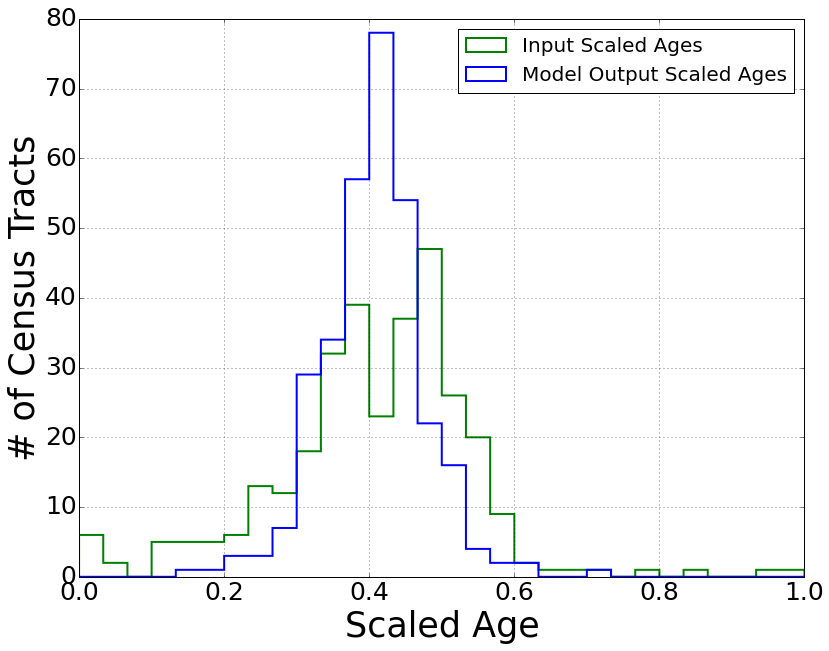

In [15]:
# save just scaled business ages out of dataframe
bus_age = features.bus_age.values

# use coefficients to calculate scaled ages for each census tract
bus_age_pred = model.predict(features)

# make histogram of scaled ages input and output
plt.figure(figsize=(13, 10))
plt.hist([bus_age_pred,bus_age], bins=30, histtype='step', align='mid', linewidth=2, \
         label=['Model Output Scaled Ages','Input Scaled Ages'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Scaled Age',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
print np.mean(bus_age_pred)
print np.median(bus_age_pred)
print np.std(bus_age_pred)

In [16]:
# read in min/max values for each feature
minmax = pd.read_csv('data_final/min_max_features.csv',index_col=0)
minmax

,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,n_businesses_42,...,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,walk_score,transit_score,bike_score,total_amount
min_max,,,,,,,,,,,,,,,,,,,,,
max_vals,1.0,3281.0,4.0,1.0,8.0,185.0,34.0,40.0,148.0,264.0,...,172846.0,230179.0,188750.0,3688.0,4000.0,2000.0,97.0,81.0,84.0,191205635.0
min_vals,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# define list of simple NAICS business codes
codes = [11,21,22,23,31,32,33,42,44,45,48,49,51,52,53,54,55,56,61,62,71,72,81,92]

# initialize lists of tracts, codes, and final predicted ages
tracts_final = np.ndarray(0)
codes_final = np.ndarray(0)
bus_age_pred_final = np.ndarray(0)
bus_age_diff_final = np.ndarray(0)

# go through each code
for code in codes:
    # reset new features dataframe
    new_features = features.copy()
    
    # save min/max of total business count
    temp_min = minmax.loc['min_vals']['n_business']
    temp_max = minmax.loc['max_vals']['n_business']
    # unscale total business count
    temp_n_bus = new_features['n_business'] * (temp_max-temp_min) + temp_min
    # increment total business count
    temp_n_bus += 1
    # rescale and save new total business count
    new_features['n_business'] = (temp_n_bus-temp_min) / (temp_max-temp_min)
    
    # save min/max of current code business count
    temp_min = minmax.loc['min_vals']['n_businesses_'+str(code)]
    temp_max = minmax.loc['max_vals']['n_businesses_'+str(code)]
    # unscale total business count
    temp_n_bus = new_features['n_businesses_'+str(code)] * (temp_max-temp_min) + temp_min
    # increment total business count
    temp_n_bus += 1
    # rescale and save new total business count
    new_features['n_businesses_'+str(code)] = (temp_n_bus-temp_min) / (temp_max-temp_min)

    # make predictions for this code for all tracts
    bus_age_pred = model.predict(new_features)
    # calculate change in age
    bus_age_diff = bus_age_pred - new_features['bus_age']
    
    # update lists of tracts, codes, and final predicted ages
    tracts_final = np.concatenate((tracts_final,new_features.census_tract.values))
    codes_final = np.concatenate((codes_final,[code]*len(bus_age_pred)))
    bus_age_pred_final = np.concatenate((bus_age_pred_final,bus_age_pred))
    bus_age_diff_final = np.concatenate((bus_age_diff_final,bus_age_diff))

In [18]:
# check stuff that will be saved
print tracts_final.shape
#tracts_final[:400]
print codes_final.shape
#codes_final[:400]
print bus_age_pred_final.shape
#bus_age_pred_final[:400]
print bus_age_diff_final.shape
#bus_age_diff_final[:400]

(7536,)
(7536,)
(7536,)
(7536,)


0.406426459222
0.40727575826
0.0689749877462


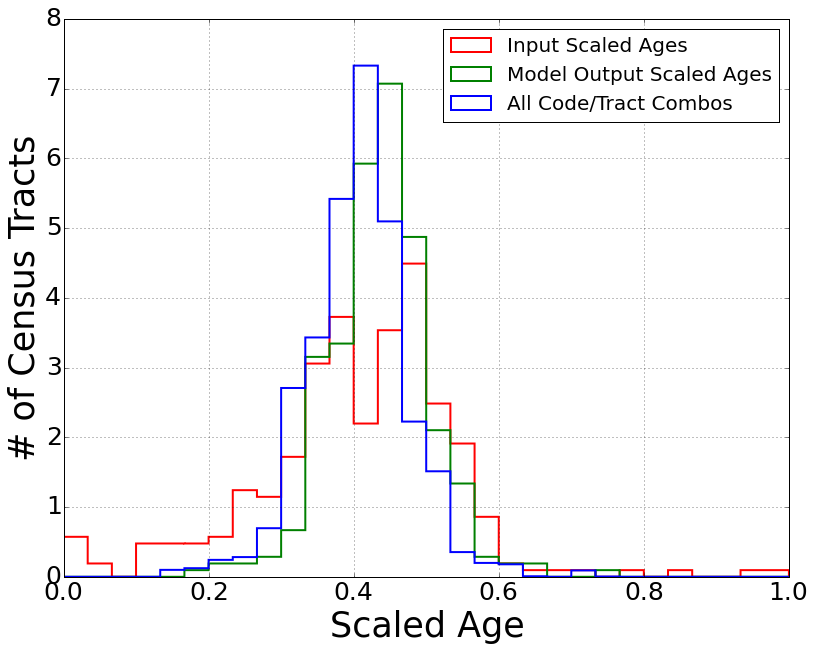

In [19]:
# make histogram of scaled ages input and output and final output (for each business/tract combo)
plt.figure(figsize=(13, 10))
plt.hist([bus_age_pred_final,bus_age_pred,bus_age], bins=30, histtype='step', align='mid', linewidth=2, normed=1, \
         label=['All Code/Tract Combos','Model Output Scaled Ages','Input Scaled Ages'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Scaled Age',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
print np.mean(bus_age_pred_final)
print np.median(bus_age_pred_final)
print np.std(bus_age_pred_final)

In [20]:
# save lists of tracts, codes, and final predicted ages as a dataframe
df_out = pd.DataFrame({'census_tract': tracts_final, 'code_simple': codes_final, \
                       'predicted_bus_age': bus_age_pred_final})
print df_out.shape
print df_out[:520]

(7536, 3)
     census_tract  code_simple  predicted_bus_age
0           100.0         11.0           0.475281
1           201.0         11.0           0.454427
2           202.0         11.0           0.433680
3           300.0         11.0           0.506964
4           400.0         11.0           0.433162
5           500.0         11.0           0.454453
6           600.0         11.0           0.414474
7           700.0         11.0           0.393305
8           800.0         11.0           0.409837
9           900.0         11.0           0.378384
10         1000.0         11.0           0.463462
11         1100.0         11.0           0.498617
12         1200.0         11.0           0.402440
13         1300.0         11.0           0.351062
14         1400.0         11.0           0.384489
15         1500.0         11.0           0.409594
16         1600.0         11.0           0.356132
17         1700.0         11.0           0.415645
18         1800.0         11.0          

In [21]:
# scale diffs to 0 to 100
bus_age_diff_final = 100*(bus_age_diff_final-min(bus_age_diff_final)) / (max(bus_age_diff_final)-min(bus_age_diff_final))
# save lists of tracts, codes, and final predicted ages as a dataframe
df_diff_out = pd.DataFrame({'census_tract': tracts_final, 'code_simple': codes_final, \
                           'score': bus_age_diff_final})
print df_diff_out.shape
print df_diff_out[:520]

(7536, 3)
     census_tract  code_simple      score
0           100.0         11.0  50.910527
1           201.0         11.0  49.197202
2           202.0         11.0  46.773469
3           300.0         11.0  59.608963
4           400.0         11.0  49.245610
5           500.0         11.0  58.073068
6           600.0         11.0  60.211548
7           700.0         11.0  52.249644
8           800.0         11.0  62.413881
9           900.0         11.0  68.895097
10         1000.0         11.0  69.895111
11         1100.0         11.0  62.582756
12         1200.0         11.0  62.347811
13         1300.0         11.0  55.450624
14         1400.0         11.0  55.890558
15         1500.0         11.0  70.232979
16         1600.0         11.0  46.382473
17         1700.0         11.0  72.946382
18         1800.0         11.0  51.573903
19         1900.0         11.0  59.980722
20         2001.0         11.0  60.705038
21         2002.0         11.0  46.163696
22         2100.0       

In [22]:
# make new dataframe for heat map plotting
df_map = df_out.pivot(index='census_tract', columns='code_simple', values='predicted_bus_age')
print df_map.shape
df_map

(314, 24)


code_simple,11.0,21.0,22.0,23.0,31.0,32.0,33.0,42.0,44.0,45.0,...,53.0,54.0,55.0,56.0,61.0,62.0,71.0,72.0,81.0,92.0
census_tract,,,,,,,,,,,,,,,,,,,,,
100.0,0.475281,0.467384,0.467384,0.480642,0.475805,0.476551,0.479294,0.478461,0.480053,0.479396,...,0.479229,0.480194,0.486298,0.479756,0.479355,0.480070,0.478942,0.477254,0.480424,0.509083
201.0,0.454427,0.446530,0.446530,0.459788,0.454951,0.455697,0.458439,0.457607,0.459199,0.458542,...,0.458375,0.459340,0.465444,0.458902,0.458501,0.459216,0.458088,0.456400,0.459570,0.488229
202.0,0.433680,0.425783,0.425783,0.439041,0.434204,0.434950,0.437692,0.436860,0.438452,0.437795,...,0.437628,0.438593,0.444697,0.438155,0.437754,0.438469,0.437341,0.435653,0.438823,0.467482
300.0,0.506964,0.499067,0.499067,0.512325,0.507489,0.508234,0.510977,0.510144,0.511736,0.511079,...,0.510912,0.511877,0.517981,0.511440,0.511038,0.511753,0.510625,0.508937,0.512107,0.540767
400.0,0.433162,0.425265,0.425265,0.438522,0.433686,0.434432,0.437174,0.436341,0.437933,0.437277,...,0.437110,0.438075,0.444179,0.437637,0.437236,0.437951,0.436823,0.435134,0.438304,0.466964
500.0,0.454453,0.446555,0.446555,0.459813,0.454977,0.455722,0.458465,0.457632,0.459224,0.458568,...,0.458400,0.459366,0.465470,0.458928,0.458527,0.459242,0.458113,0.456425,0.459595,0.488255
600.0,0.414474,0.406577,0.406577,0.419834,0.414998,0.415744,0.418486,0.417653,0.419245,0.418589,...,0.418422,0.419387,0.425491,0.418949,0.418548,0.419263,0.418135,0.416446,0.419616,0.448276
700.0,0.393305,0.385407,0.385407,0.398665,0.393829,0.394574,0.397317,0.396484,0.398076,0.397419,...,0.397252,0.398217,0.404322,0.397780,0.397378,0.398094,0.396965,0.395277,0.398447,0.427107
800.0,0.409837,0.401940,0.401940,0.415197,0.410361,0.411106,0.413849,0.413016,0.414608,0.413952,...,0.413785,0.414750,0.420854,0.414312,0.413911,0.414626,0.413497,0.411809,0.414979,0.443639


In [23]:
# make new dataframe for heat map plotting
df_map_diff = df_diff_out.pivot(index='census_tract', columns='code_simple', values='score')
print df_map_diff.shape
df_map_diff

(314, 24)


code_simple,11.0,21.0,22.0,23.0,31.0,32.0,33.0,42.0,44.0,45.0,...,53.0,54.0,55.0,56.0,61.0,62.0,71.0,72.0,81.0,92.0
census_tract,,,,,,,,,,,,,,,,,,,,,
100.0,50.910527,50.125176,50.125176,51.443595,50.962654,51.036783,51.309536,51.226720,51.385036,51.319738,...,51.303107,51.399094,52.006134,51.355574,51.315663,51.386777,51.274560,51.106670,51.421916,54.272031
201.0,49.197202,48.411852,48.411852,49.730270,49.249329,49.323458,49.596211,49.513395,49.671711,49.606413,...,49.589782,49.685769,50.292809,49.642250,49.602339,49.673452,49.561236,49.393345,49.708592,52.558706
202.0,46.773469,45.988118,45.988118,47.306537,46.825596,46.899725,47.172477,47.089661,47.247978,47.182680,...,47.166049,47.262035,47.869075,47.218516,47.178605,47.249718,47.137502,46.969611,47.284858,50.134973
300.0,59.608963,58.823612,58.823612,60.142031,59.661090,59.735219,60.007972,59.925155,60.083472,60.018174,...,60.001543,60.097530,60.704570,60.054010,60.014099,60.085213,59.972996,59.805105,60.120352,62.970467
400.0,49.245610,48.460259,48.460259,49.778678,49.297737,49.371866,49.644619,49.561803,49.720119,49.654821,...,49.638190,49.734177,50.341217,49.690658,49.650747,49.721860,49.609644,49.441753,49.757000,52.607114
500.0,58.073068,57.287717,57.287717,58.606136,58.125195,58.199324,58.472077,58.389261,58.547577,58.482279,...,58.465648,58.561635,59.168675,58.518115,58.478204,58.549318,58.437101,58.269211,58.584457,61.434572
600.0,60.211548,59.426197,59.426197,60.744616,60.263675,60.337804,60.610557,60.527740,60.686057,60.620759,...,60.604128,60.700115,61.307155,60.656595,60.616684,60.687798,60.575581,60.407690,60.722937,63.573052
700.0,52.249644,51.464293,51.464293,52.782712,52.301771,52.375900,52.648653,52.565837,52.724153,52.658855,...,52.642224,52.738211,53.345251,52.694691,52.654780,52.725894,52.613677,52.445787,52.761033,55.611148
800.0,62.413881,61.628531,61.628531,62.946949,62.466008,62.540137,62.812890,62.730074,62.888390,62.823092,...,62.806461,62.902448,63.509488,62.858929,62.819018,62.890131,62.777915,62.610024,62.925271,65.775385


In [24]:
# propagate business ages for each tract through each business type
age_code_og = np.vstack([features.bus_age.values]*24).T

In [25]:
# get change in business age after adding a new business
diff_ages = df_map.values - age_code_og
print df_map.values[:3]
print age_code_og[:3]
diff_ages

[[ 0.4752812   0.46738394  0.46738394  0.48064157  0.47580537  0.47655079
   0.47929351  0.47846074  0.48005272  0.4793961   0.48070404  0.47974996
   0.47642694  0.47692082  0.47922886  0.48019408  0.48629829  0.47975646
   0.47935513  0.48007022  0.47894181  0.47725355  0.48042358  0.50908349]
 [ 0.45442718  0.44652992  0.44652992  0.45978755  0.45495135  0.45569677
   0.45843949  0.45760672  0.4591987   0.45854208  0.45985002  0.45889594
   0.45557292  0.4560668   0.45837484  0.45934006  0.46544427  0.45890244
   0.45850111  0.4592162   0.45808779  0.45639953  0.45956956  0.48822947]
 [ 0.43368016  0.4257829   0.4257829   0.43904053  0.43420433  0.43494975
   0.43769247  0.43685969  0.43845168  0.43779506  0.439103    0.43814892
   0.4348259   0.43531978  0.43762782  0.43859304  0.44469725  0.43815542
   0.43775409  0.43846918  0.43734077  0.43565251  0.43882254  0.46748245]]
[[ 0.54187629  0.54187629  0.54187629  0.54187629  0.54187629  0.54187629
   0.54187629  0.54187629  0.54187

array([[-0.0665951 , -0.07449235, -0.07449235, ..., -0.06462275,
        -0.06145272, -0.0327928 ],
       [-0.08382379, -0.09172104, -0.09172104, ..., -0.08185143,
        -0.0786814 , -0.05002149],
       [-0.10819614, -0.11609339, -0.11609339, ..., -0.10622379,
        -0.10305376, -0.07439385],
       ..., 
       [-0.05259915, -0.06049641, -0.06049641, ..., -0.0506268 ,
        -0.04745677, -0.01879686],
       [ 0.01161119,  0.00371393,  0.00371393, ...,  0.01358354,
         0.01675357,  0.04541348],
       [ 0.20327714,  0.19537988,  0.19537988, ...,  0.20524949,
         0.20841952,  0.23707943]])

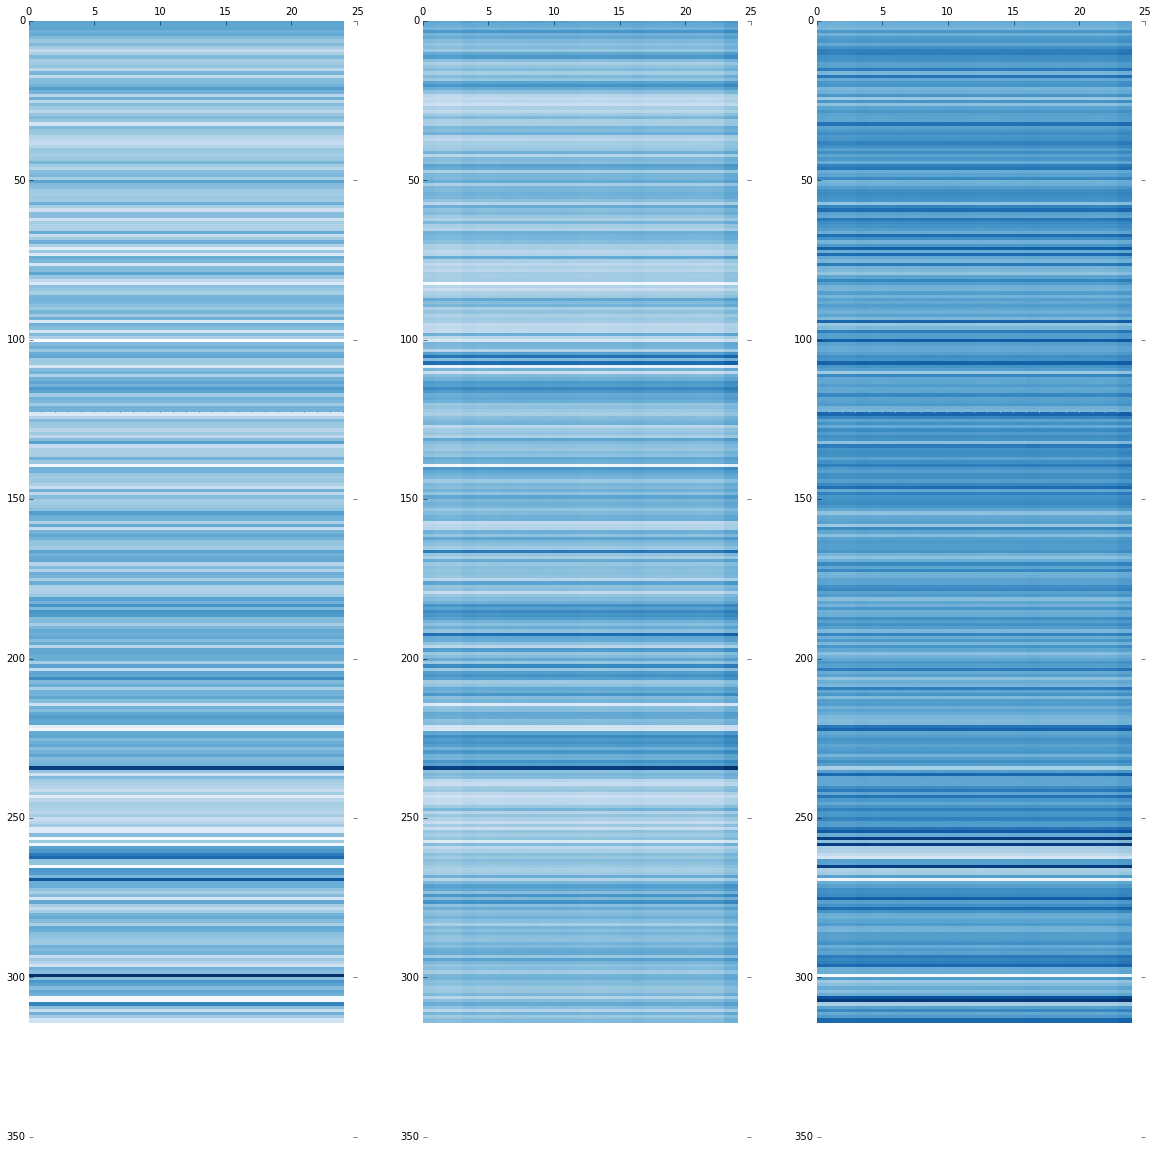

In [26]:
# make figure for heat map
fig, ax = plt.subplots(1,3)

# heat map of original business ages
heatmap = ax[0].pcolor(age_code_og,cmap=plt.cm.Blues)
# fix presentation
fig = plt.gcf()
fig.set_size_inches(20, 20)
# turn off the frame
ax[0].set_frame_on(False)
# want a more natural, table-like display
ax[0].invert_yaxis()
ax[0].xaxis.tick_top()
ax[0].grid(False)

# heat map of model output business ages for every tract/code combo
heatmap = ax[1].pcolor(df_map.values,cmap=plt.cm.Blues)
# turn off the frame
ax[1].set_frame_on(False)
# want a more natural, table-like display
ax[1].invert_yaxis()
ax[1].xaxis.tick_top()
ax[1].grid(False)

# heat map of relative diffs
heatmap = ax[2].pcolor(diff_ages,cmap=plt.cm.Blues)
# turn off the frame
ax[2].set_frame_on(False)
# want a more natural, table-like display
ax[2].invert_yaxis()
ax[2].xaxis.tick_top()
ax[2].grid(False)

plt.show()

57.5229906933
57.0551251655
11.6534739965


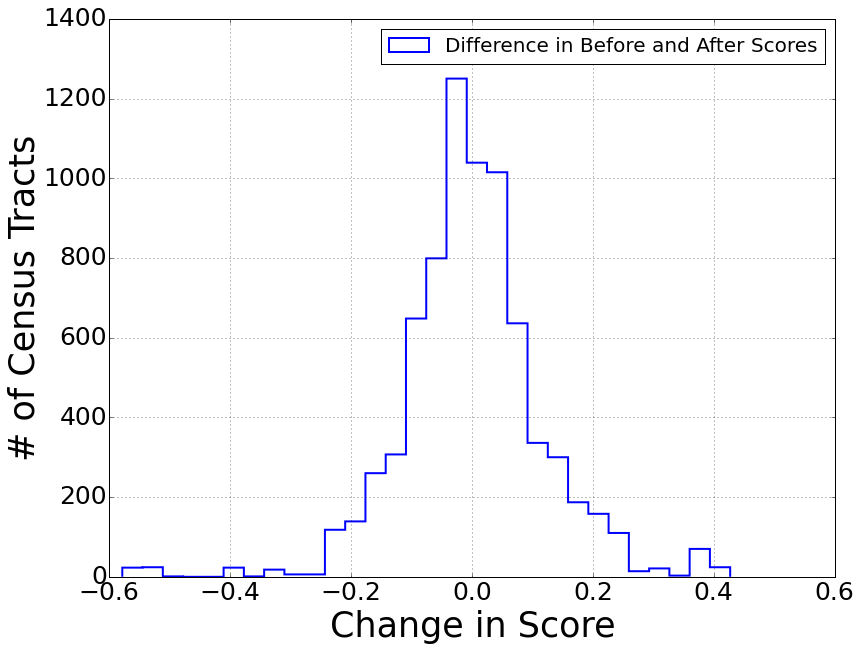

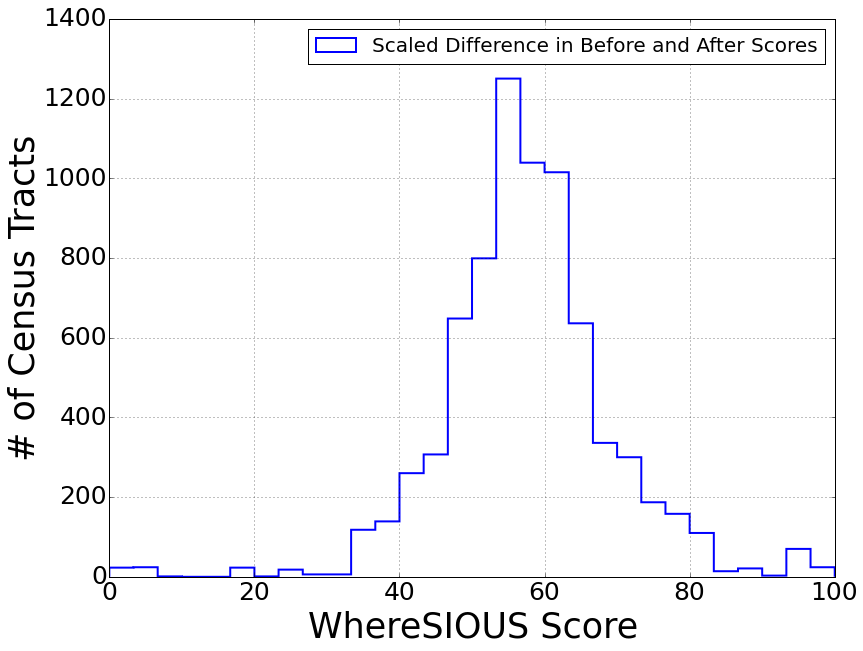

In [28]:
# flatten diffs for histogram purposes
diff_ages = diff_ages.flatten()

# make histogram of diffs
plt.figure(figsize=(13, 10))
plt.hist(diff_ages, bins=30, histtype='step', align='mid', linewidth=2, \
         label=['Difference in Before and After Scores'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Change in Score',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# make histogram of diffs scaled 0 to 100
plt.figure(figsize=(13, 10))
plt.hist(df_diff_out.score, bins=30, histtype='step', align='mid', linewidth=2, \
         label=['Scaled Difference in Before and After Scores'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('WhereSIOUS Score',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
print np.mean(df_diff_out.score)
print np.median(df_diff_out.score)
print np.std(df_diff_out.score)

In [29]:
# write dataframe of tracts, codes, and scores to csv in data_final folder and in flask static folder
df_diff_out.to_csv('data_final/tracts_codes_scores.csv')
df_diff_out.to_csv('wheresious/static/tracts_codes_scores.csv')

In [30]:
# test reading in dataframe of tracts, codes, and scores
temp = pd.read_csv('data_final/tracts_codes_scores.csv',index_col=0)
print temp.shape
temp[:10]

# test looking up a score given a tract and code
tract = 9104
code = 21
# get correct row of dataframe
score_row = temp[(temp.census_tract==tract) & (temp.code_simple==code)].score
# get score itself
score = score_row.values[0]
# format score to one decimal place
result = '{:.1f}'.format(score)
print result

(7536, 3)
55.1
